In [20]:
import os.path
import sys
import logging
import csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble
import sklearn.pipeline

sys.path.append("../../")  # trick to import clairvoya from internal notebook directory
import clairvoya.runbench
import clairvoya.pulearning
import clairvoya.voya_plotter
import clairvoya.datasetup
import cPickle as pickle

%matplotlib inline

voya_logger = logging.getLogger('voya_notebook')
voya_logger.setLevel(logging.INFO)

# Run Conditions

In [21]:
train_num_pos = 100
train_num_unlab = 1000

test_num_all = 3000
test_num_pos_frac = 0.5

num_runs_per = 20

# gamma_range = (0.1, 0.5, 0.8, )
gamma_range = (0.9, 0.8, 0.7, 0.6) # 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 

# Distributions
Gaussian1_mean = [0,0]
Gaussian2_mean = [1,1]

Gaussian1_cov = [[1, 0.5], [0.5, 1]]
Gaussian2_cov = [[1, -0.5], [-0.5, 1]]

In [22]:
# Generate Gaussian Functions
Gaussian1 = lambda n_samp: np.random.multivariate_normal(Gaussian1_mean, Gaussian1_cov, n_samp)
Gaussian2 = lambda n_samp: np.random.multivariate_normal(Gaussian2_mean, Gaussian2_cov, n_samp)

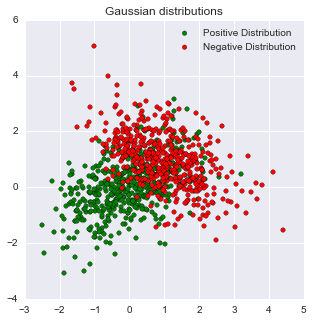

In [23]:
plot_samples = 500
plot_g1 = Gaussian1(plot_samples)
plot_g2 = Gaussian2(plot_samples)

fig = plt.figure(figsize=(5,5))
plt.scatter(plot_g1[:,0], plot_g1[:,1], c='green', label="Positive Distribution")
plt.scatter(plot_g2[:,0], plot_g2[:,1], c='red', label="Negative Distribution")
plt.title('Gaussian distributions')
plt.legend()

In [24]:
def generate_gaussian_features_array(Gaussian, num, label):
    data = Gaussian(num)
    label = np.ones(num) * label
    x_1 = data[:,0]
    x_2 = data[:,1]
    
    features_array = np.column_stack((label, label, x_1, x_2, x_1*x_2, x_1**2, x_2**2))
    return features_array

def generate_mixed_df(num_sample, frac_pos, global_label=None):
    num_pos = int(num_sample*frac_pos)
    num_neg = int(num_sample - num_pos)
    
    features_arr_pos = generate_gaussian_features_array(Gaussian1, num_pos, 1)
    features_arr_neg = generate_gaussian_features_array(Gaussian2, num_neg, 0)
    
    features_arr = np.vstack((features_arr_pos, features_arr_neg))
    mixed_df = pd.DataFrame(features_arr, columns=("fake_id", "label", "X_1", "X_2", "X_1 * X_2", "X_1**2", "X_2**2"))
    
    if global_label is not None:
        mixed_df['label'] = global_label
    
    return mixed_df

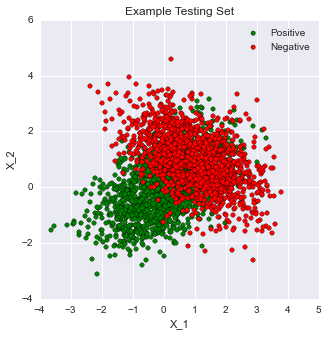

In [25]:
df = generate_mixed_df(test_num_all, 0.5)
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
df[df["label"]==1].plot(kind="scatter", x="X_1", y="X_2", c='green', ax=ax1, label="Positive")
df[df["label"]==0].plot(kind="scatter", x="X_1", y="X_2", c='red', ax=ax1, label="Negative")
plt.title("Example Testing Set")

In [26]:
pd.value_counts(df[['label']].values.ravel()) # Sanity Check

1    1500
0    1500
dtype: int64

In [27]:
# Generate test data set
gamma = 0.5
train_unlabeled = generate_mixed_df(train_num_unlab, gamma, global_label=0)
train_positive = generate_mixed_df(train_num_pos, 1)
train_df = train_positive.append(train_unlabeled, ignore_index=True)
print pd.value_counts(train_df[['label']].values.ravel()) # Sanity Check
train_df.head()

0    1000
1     100
dtype: int64


,fake_id,label,X_1,X_2,X_1 * X_2,X_1**2,X_2**2
0,1,1,0.568464,0.808311,0.459496,0.323151,0.653367
1,1,1,0.946022,1.140092,1.078552,0.894958,1.299809
2,1,1,-1.181119,-1.283623,1.516112,1.395043,1.647689
3,1,1,0.028403,-0.693807,-0.019706,0.000807,0.481368
4,1,1,0.385240,0.887688,0.341973,0.148410,0.787990


In [28]:
test_df = generate_mixed_df(test_num_all, test_num_pos_frac)
print pd.value_counts(test_df[['label']].values.ravel()) # Sanity Check
test_df.head()

1    1500
0    1500
dtype: int64


,fake_id,label,X_1,X_2,X_1 * X_2,X_1**2,X_2**2
0,1,1,0.223208,-0.224387,-0.050085,0.049822,0.050349
1,1,1,-1.256436,-2.046013,2.570684,1.578631,4.186169
2,1,1,-0.041099,0.190826,-0.007843,0.001689,0.036414
3,1,1,1.883383,1.416415,2.667652,3.547133,2.006231
4,1,1,-0.209304,-0.906433,0.189720,0.043808,0.821621


# Configuring the benchmark

In [29]:
# Classifiers
LR_estimator = sklearn.linear_model.LogisticRegression()
lsvm_estimator = sklearn.svm.LinearSVC()

LRPosOnly = sklearn.pipeline.Pipeline([
    ('lr' , LR_estimator),
    ('po', clairvoya.pulearning.PosOnly(LR_estimator)),
])

LSVMPosOnly = sklearn.pipeline.Pipeline([
    ('svm' , lsvm_estimator),
    ('po', clairvoya.pulearning.PosOnly(lsvm_estimator)),
])

LSVMDoubleWeight = sklearn.pipeline.Pipeline([
    ('svm' , lsvm_estimator),
    ('dw', clairvoya.pulearning.PULearnByDoubleWeighting(lsvm_estimator)),
])

LRDoubleWeight = sklearn.pipeline.Pipeline([
    ('lr' , LR_estimator),
    ('dw', clairvoya.pulearning.PULearnByDoubleWeighting(LR_estimator)),
])

In [35]:
save_file = 'result_data/gaussian_test_results.csv'

config = {
    "out_path": None,
    "num_cores": 3,
    "verbosity": 0,
}

classifiers = {
    # Bagging eventually breaks with too many open files error
#     'LR_Bagging': clairvoya.pulearning.PUBagging(LR_estimator, n_estimators=50, max_samples=0.5,),
#     'SVM_Bagging': clairvoya.pulearning.PUBagging(svc_estimator, n_estimators=50, max_samples=0.5,),
    # PU
    'LR_PosOnly(E&N2008)': LRPosOnly,
#     'LSVM_PosOnly(E&N2008)': LSVMPosOnly,  # Cant predict proba

#     'LSVM_DoubleWeight(E&N2008)': LSVMDoubleWeight,
#     'LR_DoubleWeight(E&N2008)': LRDoubleWeight,  # fit() got an unexpected keyword argument 'sample_weight'
    
    # Normal
    'Logistic Regression': sklearn.linear_model.LogisticRegression(),
    'Gradient Boosting': sklearn.ensemble.GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2),
    'Random Forest': sklearn.ensemble.RandomForestClassifier(n_jobs=config["num_cores"]),
}

classifiers_gridparameters = { # Gridsearch off
#     'LR_Bagging': {'po__n_estimators': [30, 100], 'po__max_samples': [0.1, 0.3, 0.7, 1.0],
#                    'lr__fit_intercept': [True, False], 'lr__C': [0.1, 0.3, 0.7, 1.0],}
    'LSVM_PosOnly(E&N2008)' : {'po__hold_out_ratio': [0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
                               'svm__C': [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]},
    
    'LR_PosOnly(E&N2008)': {'po__hold_out_ratio': [0.02, 0.05, 0.1, 0.2, 0.3, 0.5],
                           'lr__fit_intercept': [True], 'lr__C': [0.1, 0.3, 0.5, 0.7, 1.0]},

    'LSVM_DoubleWeight(E&N2008)': {'svm__C': [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]},
    'LR_DoubleWeight(E&N2008)': {'lr__fit_intercept': [True], 'lr__C': [0.1, 0.3, 0.5, 0.7, 1.0]},

    'Logistic Regression': {'fit_intercept': [True], 'C': [0.1, 0.3, 0.5, 0.7, 1.0]},
    'Gradient Boosting': {"n_estimators": [10, 30, 50, 70, 100], 'learning_rate': [0.1, 0.3, 0.7, 1.0],
                          'max_depth': [1, 2, 3, 4, 5, 7, 10]},

    'Random Forest': {"n_estimators": [10, 30, 50, 70, 100], 'max_depth': [1, 2, 3, 4, 5, 7, 10]},
}


Now run it

In [ ]:
if not os.path.exists(save_file):
    with open(save_file, 'wb') as f:
        f.write('clf,auc,gamma\n')

auc_results = {clf_name:[] for clf_name in classifiers.keys()}
for g_num, gamma in enumerate(gamma_range):
    voya_logger.info('Running classifiers for gamma={} ({}/{})'.format(gamma, g_num, len(gamma_range)))
    run_results = {clf_name:[] for clf_name in classifiers.keys()}
    for i in xrange(num_runs_per):
        train_unlabeled = generate_mixed_df(train_num_unlab, gamma, global_label=0)
        train_positive = generate_mixed_df(train_num_pos, 1)
        
        train_df = train_positive.append(train_unlabeled, ignore_index=True)
        test_df = generate_mixed_df(test_num_all, test_num_pos_frac)
        
        config.update({"test_df": test_df, "train_df": train_df,})

        results_dict = clairvoya.runbench.run_benchmark(config, classifiers, classifiers_gridparameters)
        
        # Output
        csv_output = []
        for clf_name in classifiers.keys():
            csv_output.append((clf_name, results_dict[clf_name]['auc_score'], gamma))
            
        with open(save_file, 'ab') as f:
            csv_f = csv.writer(f)
            csv_f.writerows(csv_output)
            
    for clf_name in classifiers.keys():
        auc_results[clf_name].append(run_results[clf_name])

INFO:voya_notebook:Running classifiers for gamma=0.9 (0/4)


# Process results

Note that this section can be ndone independantly (after imports)

In [32]:
results_df = pd.read_csv(save_file)
results_table = results_df.groupby(["clf", "gamma"], as_index=False).agg(['mean', 'std', 'count'])

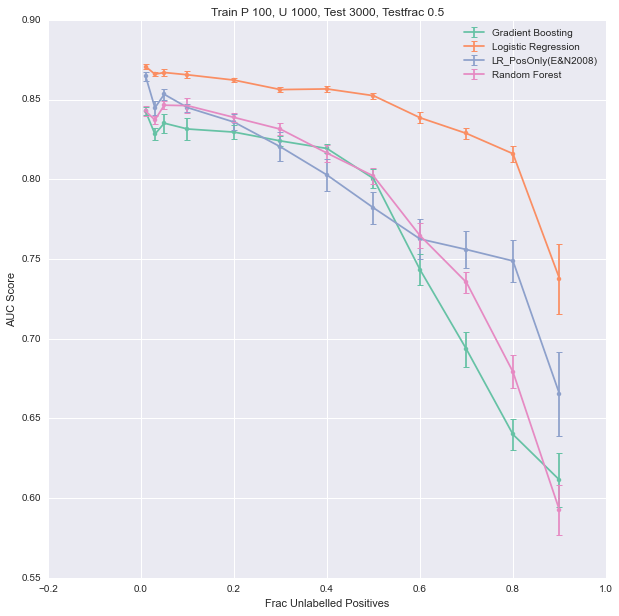

In [33]:
colors = seaborn.color_palette("Set2", 10)
result_classifiers = results_df.clf.unique()

plt.figure(figsize=(10,10))
for i, clf_name in enumerate(result_classifiers):
    clf_results = results_table.ix[(clf_name)]
    clf_gamma_range = clf_results.index
    auc_mean = clf_results.auc["mean"]
    auc_std = clf_results.auc["std"]
    auc_count = clf_results.auc["count"]
    auc_std_err = auc_std / np.sqrt(auc_count)
    
    plt.errorbar(clf_gamma_range, auc_mean, yerr=auc_std_err, label=clf_name,
                 c=colors[i], capthick=1)
    plt.scatter(clf_gamma_range, auc_mean, c=colors[i], lw=0)
    
    plt.ylabel('AUC Score')
    plt.xlabel('Frac Unlabelled Positives')
    plt.legend()
    
    title = "Train P {}, U {}, Test {}, Testfrac {}".format(
        train_num_pos, train_num_unlab, test_num_all, test_num_pos_frac)
    plt.title(title)
    plt.savefig(title + '.png')